The aim of this exercise is to train you in debugging networks using the good old print function and also tensorboard. To simulate poor training, we will train a multilayer perceptron using the CIFAR data.

1. Use the CIFAR data set reader from the first homework and read the CIFAR-10 files again. 
2. Apply random noise to the image 
3. Convert the image to float and scale to [0.0, 1.0] by dividing the pixel values by the highest pixel value.
4. Convert all labels to onehot encoding
5. Build a 3-layer multilayer perceptron of size [512, 256, 128]. 
6. Create a tensorboard summary for plotting the histogram of the weights of the three layers.
7. Also write the cost / loss at the end of each epoch to tensorboard.
8. Train the network with learning rates of [0.1, 0.01, 0.001]. You will notice that the network will not converge well.
9. Submit the snapshot of the histograms for the three learning rates. Describe your observations.

NOTE: Please submit only ipynb files.

In [ ]:
import glob
import os
import math
import numpy as np
import operator
import functools
import random
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate, shift, zoom

In [ ]:
random.seed(3457)

In [ ]:
# Hyper-parameters
learningrate = 0.001

nhidden1 = 512
nhidden2 = 256 
nhidden3 = 128
ninput = 784
noutput = 10

noofepochs = 100
batch_size = 128
number_images_batch = 10000
image_shape = (32, 32, 3,)
image_size = functools.reduce(operator.mul, image_shape)

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
# Read all data
alldata = np.zeros((5*number_images_batch, image_size), dtype=np.int)
alllabels = []
begin = 0
end = number_images_batch
for filename in glob.glob(os.path.join("cifar-10-batches-py", "data_batch*")):
    print(filename)
    d1 = unpickle(filename)
    labels = d1[b'labels']
    data = d1[b'data']
    print(data.shape)
    alldata[begin:end,:] = data
    alllabels.extend(labels)
    begin = end
    end = end+number_images_batch
alldata = alldata.astype(np.uint8)
print(alldata.shape, type(alllabels))
print(len(alllabels))

cifar-10-batches-py\data_batch_1
(10000, 3072)
cifar-10-batches-py\data_batch_2
(10000, 3072)
cifar-10-batches-py\data_batch_3
(10000, 3072)
cifar-10-batches-py\data_batch_4
(10000, 3072)
cifar-10-batches-py\data_batch_5
(10000, 3072)
(50000, 3072) <class 'list'>
50000


In [6]:
# One-hot encode labels for all data
alllabels = np.array(alllabels)
alllabels_onehot = np.eye(noutput)[alllabels]
print(alllabels_onehot[25])

[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


In [7]:
def randnoise(data):
    # Add random noise from a Gaussian distribution with a mean of zero
    # and stdev of 2. 
    noise = np.random.normal(0, 3, data.size).reshape([-1, 3072])
    data = data+noise
    return data
#randnoise(alldata)

(128, 3072) (128, 10) [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.] 0.0 1.0
(32, 32, 3)


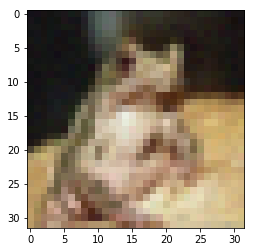

In [8]:
def getbatch(alldata, alllabels, batch_size = 16):
    nlabels = alllabels.shape[0]
    number_of_batches = nlabels//batch_size # change to nlabels
    for batch_number in range(number_of_batches):
        rand_index = np.array([random.randrange(0, nlabels) for i in range(batch_size)])        
        batch_x = alldata[rand_index]
        batch_x = randnoise(batch_x)
        batch_x = (batch_x-batch_x.min())/(batch_x.max()-batch_x.min())
        batch_y = alllabels[rand_index]
        yield (batch_x, batch_y)
    
a = getbatch(alldata, alllabels_onehot, batch_size = batch_size)
x, y = next(a)
print(x.shape, y.shape, y[5], x.min(), x.max())
oneimage = x[5].reshape(3, 32, 32).transpose(1, 2, 0)
print(oneimage.shape)
plt.imshow(oneimage)
#for x, y in getbatch(alldata, alllabels, batch_size = batch_size):
#    print(x.shape, y.shape)    

In [9]:
X = tf.placeholder(tf.float32, [None, image_size])
Y = tf.placeholder(tf.float32, [None, noutput])

In [10]:
weights = \
{
    'h1': tf.Variable(tf.random_normal([image_size, nhidden1])),
    'h2': tf.Variable(tf.random_normal([nhidden1, nhidden2])),
    'h3': tf.Variable(tf.random_normal([nhidden2, nhidden3])),
    'out': tf.Variable(tf.random_normal([nhidden3, noutput]))
}

biases = \
{
    'b1': tf.Variable(tf.random_normal([nhidden1])),
    'b2': tf.Variable(tf.random_normal([nhidden2])),
    'b3': tf.Variable(tf.random_normal([nhidden3])),
    'out': tf.Variable(tf.random_normal([noutput]))
}

In [11]:
def multiperceptron(x):
    l1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    l2 = tf.nn.sigmoid(tf.add(tf.matmul(l1, weights['h2']), biases['b2']))
    l3 = tf.nn.sigmoid(tf.add(tf.matmul(l2, weights['h3']), biases['b3']))
    outl = tf.add(tf.matmul(l3, weights['out']), biases['out'])
    return outl
    
model = multiperceptron(X)

In [12]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = model, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learningrate)
train_min = optimizer.minimize(loss)

correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Add to tensorboard summary
tf.summary.histogram("weight_1",weights['h1'])
tf.summary.histogram("weight_2",weights['h2'])
tf.summary.histogram("weight_3",weights['h3'])
tf.summary.scalar("loss", loss)
merged_summary_op = tf.summary.merge_all()
filename="./summary_log_cifar/run"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
writer = tf.summary.FileWriter(filename, tf.get_default_graph())

init = tf.global_variables_initializer()

In [13]:
with tf.Session() as sess:
    sess.run(init)    
        
    for epoch in range(noofepochs):
        #count = 0
        for batch_x, batch_y in getbatch(alldata, alllabels_onehot, batch_size = batch_size):            
            sess.run(train_min, feed_dict={X:batch_x,Y:batch_y})

        losscalc, accuracycalc, merged_summary = \
                      sess.run([loss, accuracy, merged_summary_op], feed_dict={X:batch_x, Y:batch_y})
        print("Training Loss: %0.4f, Accuracy: %0.4f"%(losscalc, accuracycalc))
        writer.add_summary(merged_summary, epoch)
        
writer.close()

Training Loss: 1.9344, Accuracy: 0.2812
Training Loss: 1.9209, Accuracy: 0.3125
Training Loss: 1.9182, Accuracy: 0.3672
Training Loss: 1.8662, Accuracy: 0.3594
Training Loss: 1.6807, Accuracy: 0.4297
Training Loss: 1.7593, Accuracy: 0.3359
Training Loss: 1.8142, Accuracy: 0.3516
Training Loss: 1.7546, Accuracy: 0.3438
Training Loss: 1.8746, Accuracy: 0.3125
Training Loss: 1.7621, Accuracy: 0.3906
Training Loss: 1.6855, Accuracy: 0.3828
Training Loss: 1.7816, Accuracy: 0.3672
Training Loss: 1.6393, Accuracy: 0.3672
Training Loss: 1.6346, Accuracy: 0.4609
Training Loss: 1.7891, Accuracy: 0.3281
Training Loss: 1.5149, Accuracy: 0.4141
Training Loss: 1.4936, Accuracy: 0.4531
Training Loss: 1.4129, Accuracy: 0.4688
Training Loss: 1.6057, Accuracy: 0.4219
Training Loss: 1.6707, Accuracy: 0.4062
Training Loss: 1.4638, Accuracy: 0.4766
Training Loss: 1.6651, Accuracy: 0.4297
Training Loss: 1.6532, Accuracy: 0.3984
Training Loss: 1.4968, Accuracy: 0.4453
Training Loss: 1.4572, Accuracy: 0.4531


### Loss:
In the figure below, you will notice that the loss does not decrease as fast as it did for MNIST data set. The accuracy (66%) is very low compared to the accuracy for MNIST data set (95%+)

<img src="results/loss_mnist.png" height="200px">

### Weights: 
If you compare the various weights, you will see that the histogram of weight1 has barely changed while weight3 underwent some change. Due to vanishing gradient in sigmoid function, the gradient flowing from weight3 reduces significantly by the time it reaches weight1. Hence the weight update will be smaller in weight1 resulting in imperceptible change to histogram. Thus, weight3 has learnt in the training while weight1 has barely learnt anything beyond its initial value.


<img src="results/weight1_cifar.png" height="200px">
<img src="results/weight2_cifar.png" height="200px">
<img src="results/weight3_cifar.png" height="200px">